In [2]:
import numpy as np
import pydae.build_cffi as db
import sympy as sym
import matplotlib.pyplot as plt
from pydae.plot_tools import set_style
colors = set_style(plt)

In [4]:
# paper: https://ieeexplore.ieee.org/document/7540938

Freq = 50.0;
Omega_b = 2*np.pi*50.0;

N = 7;
L_arm = 1.0e-3; 
R_arm = 10.0e-3; 
L_f =  1.0e-3;
R_f = 10.0e-3;
C_tot = 100e-6;

L_eq_ac = (L_arm + 2*L_f)/2;
R_eq_ac = (R_arm + 2*R_f)/2;

L_eq_dc = 2.0/3.0*L_arm;
R_eq_dc = 2.0/3.0*R_arm;

C_eq = 6*C_tot;

C_dc = 0.01;
i_dc = 0.0;
i_D = 0.0;
i_Q = 0.0;
v_C = 1.0;
v_dc = 1.0;
x_0 = [i_dc,i_D,i_Q,v_C,v_dc];

L_s = 0.1;
L_g = 0.1;
R_s = 0.01;
R_g = 0.01;
C_eq = 0.1;
G_eq = 0.001;


K_p_i = (L_g/Omega_b)/0.001;
T_p_i = (L_g/Omega_b)/R_g;
K_i_i = K_p_i/T_p_i;

K_p_idc = (2/3*L_s/Omega_b)/0.001;
T_p_idc = (2/3*L_s/Omega_b)/(2/3*R_s);
K_i_idc = K_p_idc/T_p_idc;

zeta = 1;
omega = 2*np.pi*100;

# dv_C = (-G_eq*v_C + m_o*i_dc - 3/2*(m_D*i_D + m_Q*i_Q))/(C_eq/Omega_b);
# s*v_C*(C_eq/Omega_b) = -3/2*m_Q*i_Q
# s*v_C*(C_eq/Omega_b)/(-3/2*m_Q) = i_Q

a = (C_eq/Omega_b)/(3/2*1.0);
b = 0.0;
K_p_vc = 2*zeta*omega*a-b;
K_i_vc = a*omega**2;

#K_p_vc = 2.0*C_eq;
#K_i_vc = 10*K_p_vc;

zeta = 0.8;
omega = 2*np.pi*30;
a = C_dc;
b = 0.0;
K_p_vdc = 2*zeta*omega*a-b;
K_i_vdc = a*omega**2*0.2;


In [5]:
params_dict = {
'R_s':R_s, 
'L_s':L_s, 
'C_eq':C_eq, 
'G_eq':G_eq, 
'R_g':R_g,  
'L_g':L_g, 
'Omega_b':Omega_b,
'C_dc':C_dc,   
'K_p_i':K_p_i,  
'K_i_i':K_i_i,  
'K_p_idc':K_p_idc,
'K_i_idc':K_i_idc,
'K_p_vc':K_p_vc, 
'K_i_vc':K_i_vc,
'K_p_vdc':K_p_vdc,
'K_i_vdc':K_i_vdc}

i_dc,i_D,i_Q,v_C,v_dc = sym.symbols('i_dc,i_D,i_Q,v_C,v_dc', real = True)
xi_d,xi_q,xi_idc,xi_vc,xi_vdc = sym.symbols('xi_d,xi_q,xi_idc,xi_vc,xi_vdc', real = True)

R_s,L_s,C_eq,G_eq,R_g,L_g = sym.symbols('R_s,L_s,C_eq,G_eq,R_g,L_g', real = True)
Omega_b,C_dc  = sym.symbols('Omega_b,C_dc', real = True)
K_p_i,K_i_i = sym.symbols('K_p_i,K_i_i', real = True)
K_p_idc,K_i_idc  = sym.symbols('K_p_idc,K_i_idc', real = True)
K_p_vc,K_i_vc  = sym.symbols('K_p_vc,K_i_vc', real = True)
K_p_vdc,K_i_vdc = sym.symbols('K_p_vdc,K_i_vdc', real = True)

v_dc_ref,p_load = sym.symbols('v_dc_ref,p_load', real = True)
i_d_ref,v_c_ref  = sym.symbols('i_d_ref,v_c_ref', real = True)
v_Dh,v_Qh,ws  = sym.symbols('v_Dh,v_Qh,ws', real = True)

i_load = sym.Symbol('i_load', real = True)




#Çi_load = p_load/v_dc;
i_t = i_load;

# v_dc control
epsilon_vdc = v_dc_ref - v_dc;
dxi_vdc = epsilon_vdc;
i_dc_ref = -(K_p_vdc*epsilon_vdc + K_i_vdc*xi_vdc) - i_t;
i_dc_ref_c = i_dc_ref;


# v_C control
epsilon_vc = v_c_ref - v_C;
dxi_vc = epsilon_vc;
i_q_ref = -(K_p_vc*epsilon_vc + K_i_vc*xi_vc) + 2/3*i_dc_ref;
i_q_ref_c = i_q_ref;

# ac currents control
epsilon_d = i_d_ref - i_D;
epsilon_q = i_q_ref - i_Q;
u_d = K_p_i*epsilon_d + K_i_i*xi_d;
u_q = K_p_i*epsilon_q + K_i_i*xi_q;

# di_D = (-R_g*i_D - ws*L_g*i_Q - v_Dh + m_D*v_C)/(L_g/Omega_b);
# di_Q = (-R_g*i_Q + ws*L_g*i_D - v_Qh + m_Q*v_C)/(L_g/Omega_b);
# di_D = (-R_g*i_D + u_d)/(L_g/Omega_b);
# di_Q = (-R_g*i_Q + u_q)/(L_g/Omega_b);
m_D =  ( ws*L_g*i_Q + v_Dh + u_d)/v_C;
m_Q =  (-ws*L_g*i_D + v_Qh + u_q)/v_C;


# dc current
epsilon_idc = i_dc_ref - i_dc;
u_idc = K_p_idc*epsilon_idc + K_i_idc*xi_idc;

# di_dc = (-2/3*R_s*i_dc + v_dc - m_o*v_C)/(2/3*L_s/Omega_b);
m_o = (-u_idc + v_dc)/v_C; 

dxi_d = epsilon_d;
dxi_q = epsilon_q;
dxi_idc = epsilon_idc;

di_dc = (-2/3*R_s*i_dc + v_dc - m_o*v_C)/(2/3*L_s/Omega_b);
di_D = (-R_g*i_D - ws*L_g*i_Q - v_Dh + m_D*v_C)/(L_g/Omega_b);
di_Q = (-R_g*i_Q + ws*L_g*i_D - v_Qh + m_Q*v_C)/(L_g/Omega_b);
dv_C = (-G_eq*v_C + m_o*i_dc - 3/2*(m_D*i_D + m_Q*i_Q))/(C_eq/Omega_b);
dv_dc = 1/C_dc*(-i_load - i_dc);

f_list  = [di_dc,di_D,di_Q,dv_C,dv_dc]
x_list  = [ i_dc, i_D, i_Q, v_C, v_dc]

f_list += [dxi_d,dxi_q,dxi_idc,dxi_vc,dxi_vdc]
x_list += [ xi_d, xi_q, xi_idc, xi_vc, xi_vdc]

u_dict = {'i_d_ref':0.0,'v_c_ref':1.2,'v_dc_ref':1.1,
          'v_Dh':0.0,'v_Qh':1.0,'ws':1.0,'p_load':0.0}

h_dict = {'i_q_ref':i_q_ref,'i_dc_ref':i_dc_ref,'v_dc_ref':v_dc_ref,
          'p_load':p_load,'i_load':i_load,
          'm_D':m_D,'m_Q':m_Q,'m_o':m_o}

g_list = [i_load*v_dc - p_load]
y_list = [i_load]



In [6]:
sys_dict = {'name':'mmc','uz_jacs':True,
        'params_dict':params_dict,
        'f_list':f_list,
        'g_list':g_list,
        'x_list':x_list,
        'y_ini_list':y_list,
        'y_run_list':y_list,
        'u_run_dict':u_dict,
        'u_ini_dict':u_dict,
        'h_dict':h_dict}

bldr = db.builder(sys_dict,verbose=True);
bldr.build()      

check_system (time: 0.0)
computing jacobians Fx_run,Fy_run  (time: 0.003 s)
computing jacobians Gx_run,Gy_run  (time: 0.086 s)
computing jacobians Fu_run,Gu_run  (time: 0.087 s)
computing jacobians Fx_ini,Fy_ini  (time: 0.108 s)
computing jacobians Gx_ini,Gy_ini  (time: 0.114 s)
computing jacobians Hx_run,Hy_run,Hu_run  (time: 0.1140129566192627 s)
end system  (time: 0.142 s)
computing jac_ini (time: 0.0)
computing jac_run (time: 0.0)
computing jac_trap (time: 0.0)
end of jacobians computation (time: 0.010)
writting f_ini and g_ini code (time: 0.000 s)
writting f_run and g_run code (time: 0.028 s)
writting h_run code (time: 0.046 s)
converting jac_ini to sp_jac_ini  (time: 0.057 s)
running sym2rhs for sp_jac_ini (time: 0.057 s)
converting jac_run to sp_jac_run  (time: 0.089 s)
running sym2rhs for sp_jac_run (time: 0.089 s)
converting jac_trap to sp_jac_trap  (time: 0.114 s)
running sym2rhs for sp_jac_trap (time: 0.114 s)
wrtting  de_jac_trap code (time: 0.166 s)
writting sp_jac_trap co

In [3]:
import mmc

model = mmc.model()

model.ini({'p_load':1.0},1)
model.report_x()
model.report_z()

i_dc  = -0.91
i_D   =  0.00
i_Q   = -0.68
v_C   =  1.20
v_dc  =  1.10
xi_d  =  0.00
xi_q  = -0.00
xi_idc = -0.00
xi_vc =  0.00
xi_vdc =  0.00
i_q_ref = -0.68
i_dc_ref = -0.91
v_dc_ref =  1.10
p_load =  1.00
i_load =  0.91
m_D   = -0.06
m_Q   =  0.83
m_o   =  0.92


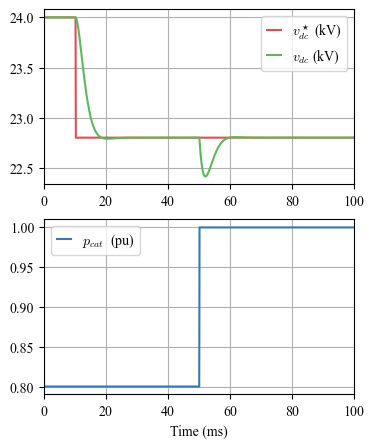

In [10]:
model = mmc.model()
model.Dt = 100e-6
model.decimation = 1
model.ini({'p_load':0.8,'v_dc_ref':1.0,'K_i_vdc':0.001},1)
model.run(0.01,{})
model.run(0.05,{'v_dc_ref':0.95})
model.run(0.1,{'p_load':1.0})
model.post();

fig,axes = plt.subplots(nrows=2, figsize=(4,5))
axes[0].plot(model.Time*1e3,24*model.get_values('v_dc_ref'),label=r'$v_{dc}^\star$ (kV)')
axes[0].plot(model.Time*1e3,24*model.get_values('v_dc'),label=r'$v_{dc}$ (kV)')

axes[1].plot(model.Time*1e3,model.get_values('p_load'),label=r'$p_{cat}$  (pu)',color=colors[2])

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,100)
ax.set_xlabel('Time (ms)')
fig.savefig('mmc_test.svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


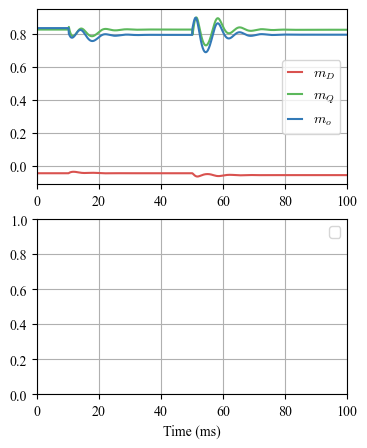

In [15]:
fig,axes = plt.subplots(nrows=2, figsize=(4,5))
axes[0].plot(model.Time*1e3,model.get_values('m_D'),label=r'$m_D$')
axes[0].plot(model.Time*1e3,model.get_values('m_Q'),label=r'$m_Q$')
axes[0].plot(model.Time*1e3,model.get_values('m_o'),label=r'$m_o$')


for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,100)
ax.set_xlabel('Time (ms)')
fig.savefig('mmc_test.png')